## 탐지할 대상 이름 설정

In [ ]:
CUSTOM_OBJECT_NAMES = ['laptop', 'keyboard']

## 0. 임포트

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob
from google.colab import drive

## 2. Darknet 다운받아서 컴파일

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15386, done.
remote: Total 15386 (delta 0), reused 0 (delta 0), pack-reused 15386
Receiving objects: 100% (15386/15386), 14.01 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (10345/10345), done.


OpenCV, GPU, CuDNN 사용 관련 설정하고 컴파일

In [ ]:
%cd darknet

[Errno 20] Not a directory: 'darknet'
/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

## 3. 학습관련 설정 파일 수정

원 설정파일 yolov3.cfg를 yolv3_custom.cfg로 복사하고

복사한 설정파일을 수정

In [ ]:
# %cd darknet

# Make a copy & rename it to yolov3_custom.cfg
!cp cfg/yolov3.cfg cfg/yolov3_custom.cfg

In [ ]:
# Change classes value to your number of objects
classes = len(CUSTOM_OBJECT_NAMES)
filters = (classes + 5) * 3
max_batches = classes * 2000

if max_batches < 6000:
  max_batches = 6000
max_batches = 500


# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/yolov3_custom.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_custom.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/yolov3_custom.cfg
!sed -i '610 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '696 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '783 s@classes=80@classes=$classes@' cfg/yolov3_custom.cfg
!sed -i '603 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '689 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg
!sed -i '776 s@filters=255@filters=$filters@' cfg/yolov3_custom.cfg

# 데이터 가져오기

In [ ]:
!ls -al /mydrive/tmp/laptops.zip

ls: cannot access '/mydrive/tmp/laptops.zip': No such file or directory


In [ ]:
!rm -rf data/obj
!mkdir data/obj
!unzip /content/darknet/laptops.zip -d data/obj

Archive:  /content/darknet/laptops.zip
  inflating: data/obj/.DS_Store      
  inflating: data/obj/1.jpg          
  inflating: data/obj/1.txt          
  inflating: data/obj/10.jpg         
  inflating: data/obj/10.txt         
  inflating: data/obj/11.jpg         
  inflating: data/obj/11.txt         
  inflating: data/obj/12.jpg         
  inflating: data/obj/12.txt         
  inflating: data/obj/2.jpg          
  inflating: data/obj/2.txt          
  inflating: data/obj/3.jpg          
  inflating: data/obj/3.txt          
  inflating: data/obj/4.jpg          
  inflating: data/obj/4.txt          
  inflating: data/obj/5.jpg          
  inflating: data/obj/5.txt          
  inflating: data/obj/6.jpg          
  inflating: data/obj/6.txt          
  inflating: data/obj/7.jpg          
  inflating: data/obj/7.txt          
  inflating: data/obj/8.jpg          
  inflating: data/obj/8.txt          
  inflating: data/obj/9.jpg          
  inflating: data/obj/9.txt          


In [ ]:
%%writefile data/obj.names
laptop
keyboard

Overwriting data/obj.names


In [ ]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = ./

Overwriting data/obj.data


In [ ]:
!cat data/obj.names

laptop
keyboard

In [ ]:
!cat data/obj.data

classes = 2
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = ./

In [ ]:
!ls -al data/obj

total 772
drwxr-xr-x 2 root root  4096 Jan  5 06:15 .
drwxr-xr-x 4 root root  4096 Jan  5 06:16 ..
-rw-r--r-- 1 root root 88643 Jan  5  2022 10.jpg
-rw-r--r-- 1 root root   151 Jan  5  2022 10.txt
-rw-r--r-- 1 root root 66846 Jan  5  2022 11.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 11.txt
-rw-r--r-- 1 root root 40143 Jan  5  2022 12.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 12.txt
-rw-r--r-- 1 root root 67386 Jan  5  2022 1.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 1.txt
-rw-r--r-- 1 root root 58558 Jan  5  2022 2.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 2.txt
-rw-r--r-- 1 root root  6796 Jan  5  2022 3.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 3.txt
-rw-r--r-- 1 root root 89436 Jan  5  2022 4.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 4.txt
-rw-r--r-- 1 root root 45128 Jan  5  2022 5.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 5.txt
-rw-r--r-- 1 root root 38503 Jan  5  2022 6.jpg
-rw-r--r-- 1 root root    75 Jan  5  2022 6.txt
-rw-r--r-- 1 root root 39121 Ja

In [ ]:
# ls -al data/obj/laptops_labeled 밑에 jpg 파일들이 있으면
images_list = glob.glob("data/obj/*[jpg|png|jpeg]")

# ls -al data/obj 밑에 jpg 파일들이 있으면
# images_list = glob.glob("data/obj/*[jpg|png|jpeg]")

print(images_list)

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

['data/obj/5.jpg', 'data/obj/10.jpg', 'data/obj/4.jpg', 'data/obj/7.jpg', 'data/obj/2.jpg', 'data/obj/6.jpg', 'data/obj/1.jpg', 'data/obj/11.jpg', 'data/obj/3.jpg', 'data/obj/9.jpg', 'data/obj/12.jpg', 'data/obj/8.jpg']


In [ ]:
!cat data/train.txt

data/obj/5.jpg
data/obj/10.jpg
data/obj/4.jpg
data/obj/7.jpg
data/obj/2.jpg
data/obj/6.jpg
data/obj/1.jpg
data/obj/11.jpg
data/obj/3.jpg
data/obj/9.jpg
data/obj/12.jpg
data/obj/8.jpg

## 5. 학습된 YOLOv3 모델 파일 다운로드

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-01-05 07:11:29--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.3’

darknet53.conv.74.3 100%[===================>] 154.96M  40.0MB/s    in 4.3s    

2022-01-05 07:11:34 (35.8 MB/s) - ‘darknet53.conv.74.3’ saved [162482580/162482580]



## 6. 학습 실행

학습된 모델은  /mydrive/tmp/custom_object_detection/yolov3_custom_last.weights 로 저장된다.

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.645659), count: 2, class_loss = 3.165673, iou_loss = 1.236697, total_loss = 4.402369 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.116493, iou_loss = 0.000000, total_loss = 0.116493 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.114127, iou_loss = 0.000000, total_loss = 0.114127 
 total_bbox = 100856, rewritten_bbox = 0.089236 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.549785), count: 2, class_loss = 3.232295, iou_loss = 2.252457, total_loss = 5.484752 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.116574, iou_loss = 0.000000, total_loss = 0.116574 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_

## 7. 탐지 실행

In [ ]:
!./darknet detect cfg/yolov3_custom.cfg /content/darknet/yolov3_custom_last_2.weights /content/darknet/data/obj/1.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 166, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortc

In [ ]:
!

/content/darknet


In [ ]:
# !./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/tmp/custom_object_detection/yolov3_custom_last.weights -thresh 0.25

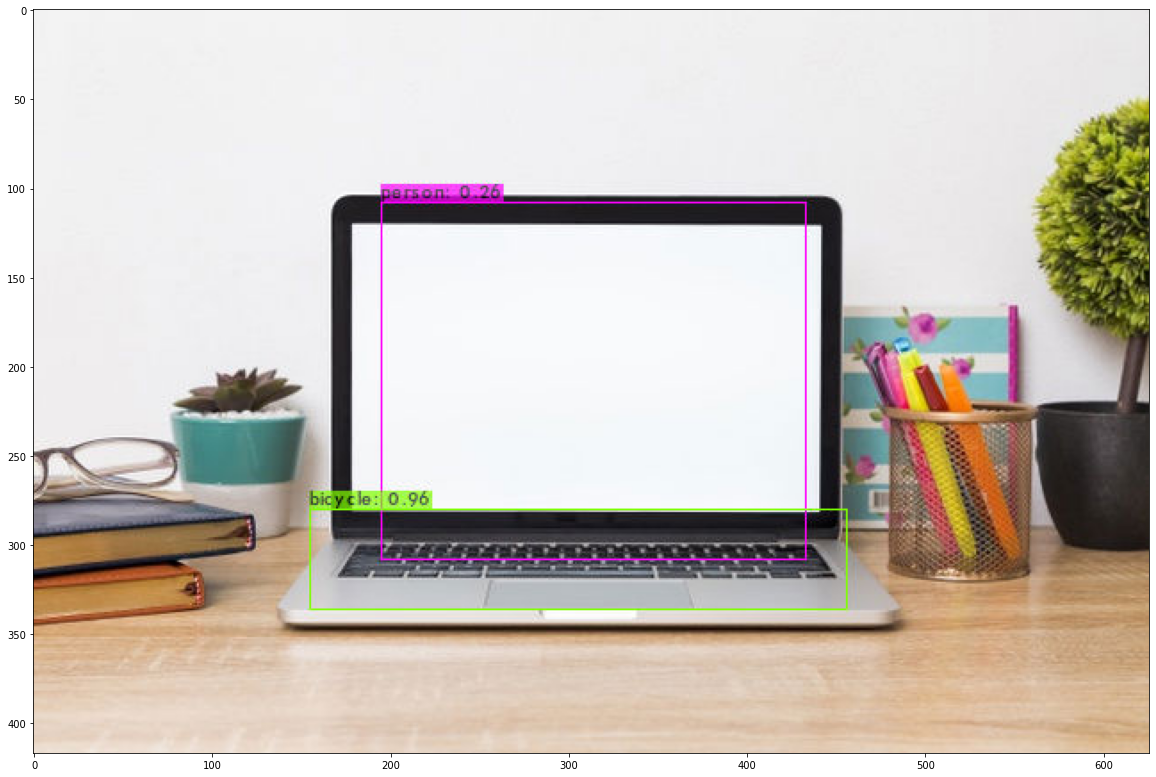

In [ ]:
pred = cv2.imread('/content/darknet/predictions.jpg')
pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(pred)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
!cp /gdrive/MyDrive/temp/yolov3_custom_last_2.weights ./

cp: cannot create regular file './yolov3_custom_last_2.weights': Operation not supported


In [ ]:
!pwd


/content/darknet


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive
